In [ ]:
# Load required libraries
library(httr)
library(jsonlite)
library(ggplot2)
library(dplyr)
library(readr)
library(pheatmap)
library(RColorBrewer)
library(tidyr)

# Install and load optional packages if available
optional_packages <- c("ComplexHeatmap", "circlize", "VennDiagram")
for (pkg in optional_packages) {
  if (!require(pkg, character.only = TRUE, quietly = TRUE)) {
    cat("Installing", pkg, "...\n")
    if (!requireNamespace("BiocManager", quietly = TRUE)) {
      install.packages("BiocManager")
    }
    BiocManager::install(pkg, quietly = TRUE)
    library(pkg, character.only = TRUE)
  }
}


## **Core Analyses Performed:**

### **1. Data Loading & API Integration**
- Queries PanKbase API for metadata on each analysis set
- Loads DEG results from S3 for all 5 cell types (Alpha, Beta, ActiveStellate, Acinar, Ductal)
- Combines datasets with proper cell type labeling

### **2. Volcano Plots**
- Individual volcano plots for each cell type
- Color-coded significance levels (upregulated/downregulated/significant/not significant)
- Thresholds: padj < 0.05 and |log2FC| > 1


### **3. Comparative Analysis**
- **Common genes**: DEGs shared across multiple cell types
- **Cell-type specific genes**: DEGs unique to single cell types
- **Summary statistics**: Total DEGs, up/downregulated counts per cell type

### **4. Additional Analyses**
- **Summary bar plot**: Visual comparison of DEG counts across cell types
- **Gene list preparation**: Ready-to-use lists for GO/KEGG enrichment analysis
- **Statistical summaries**: Comprehensive overview of results

## **Key Features:**
- **Robust error handling** for API calls and file loading
- **Flexible visualization** with customizable significance thresholds
- **Functional analysis preparation** with gene lists for downstream enrichment
- **Comprehensive reporting** with detailed statistics and summaries

## **Expected Outputs:**
- 5 volcano plots (one per cell type)
- Summary tables of DEG statistics
- Lists of cell-type specific and shared DEGs
- Bar plot comparing DEG counts across cell types

Script started at: 2025-06-24 16:09:10 
=== LOADING DEG DATASETS ===

--- Processing Alpha ---
Analysis description: RUV-normalized pseudo-bulk counts for differential expression analysis of pancreatic D cell derived from cells in the single cell RNA-seq browser v3.3 
Loading DEG data for Alpha from: https://pankbase-data-v1.s3.us-west-2.amazonaws.com/analysis_resources/single_cell_expression/20250522_data_for_platform/Alpha_k-chosen_fdr0.05_all.txt 
Successfully loaded 13651 genes for Alpha 

--- Processing Beta ---
Analysis description: RUV-normalized pseudo-bulk counts for differential expression analysis of type B pancreatic cell derived from cells in the single cell RNA-seq browser v3.3 
Loading DEG data for Beta from: https://pankbase-data-v1.s3.us-west-2.amazonaws.com/analysis_resources/single_cell_expression/20250522_data_for_platform/Beta_k-chosen_fdr0.05_all.txt 
Successfully loaded 13191 genes for Beta 

--- Processing ActiveStellate ---
Analysis description: RUV-normalized 

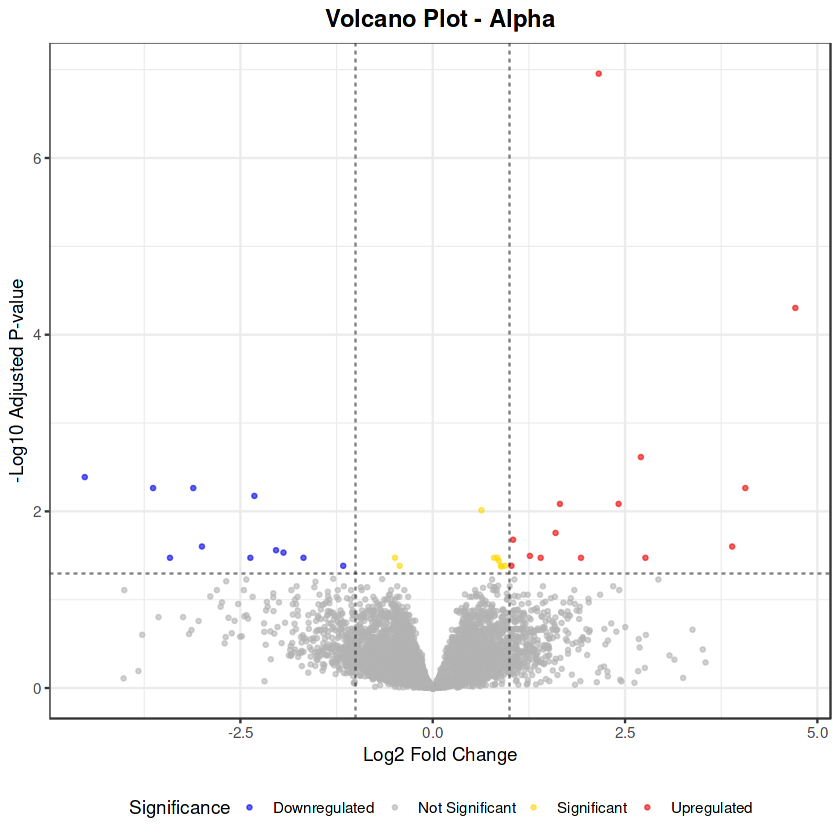

Warning message:
“Removed 5972 rows containing missing values or values outside the scale range
(`geom_point()`).”


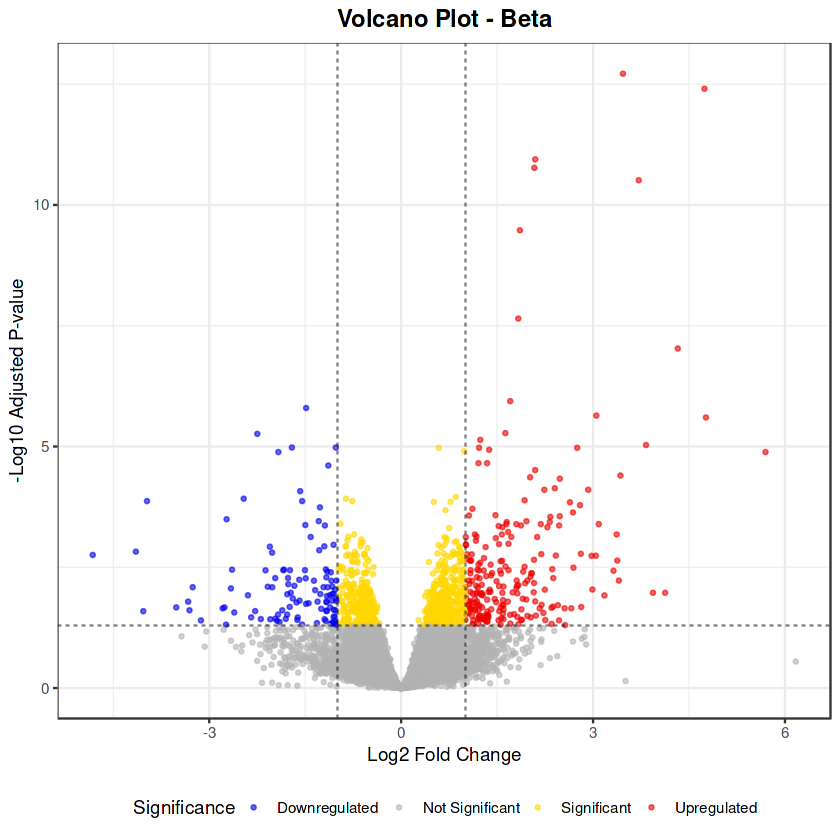

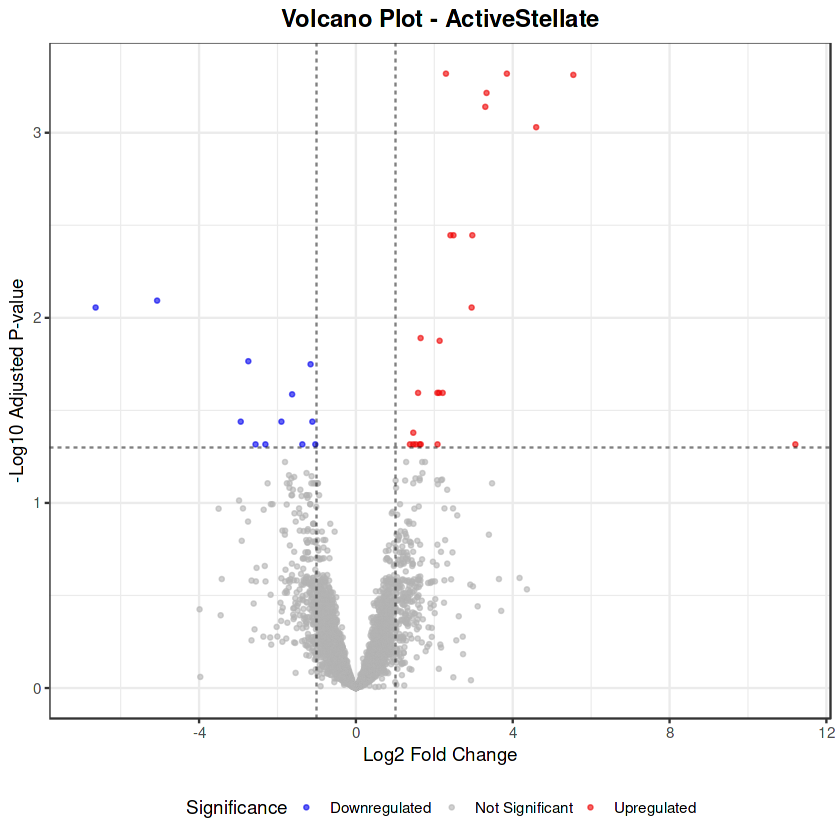

Warning message:
“Removed 707 rows containing missing values or values outside the scale range
(`geom_point()`).”


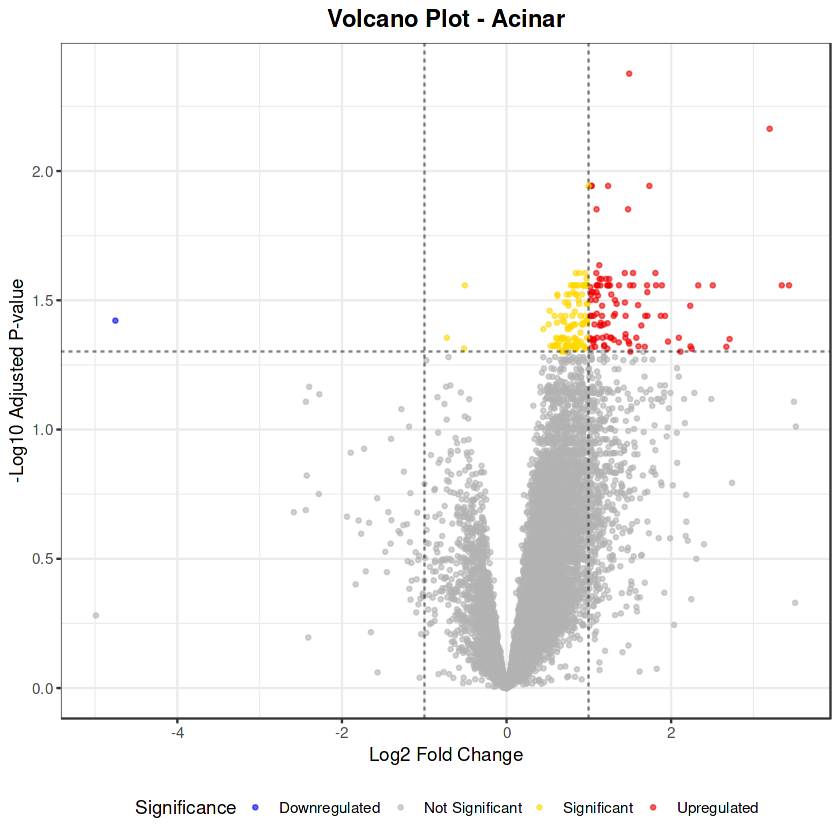


=== COMPARATIVE ANALYSIS ===
Top genes upregulated across multiple cell types:
# A tibble: 10 × 4
   gene     cell_types             n_cell_types avg_log2fc
   <chr>    <chr>                         <int>      <dbl>
 1 GBP1     Alpha, Acinar                     2       3.20
 2 ARL14EPL Alpha, Beta                       2       3.12
 3 HLA-B    Alpha, Beta                       2       2.94
 4 ETV7     Alpha, Beta                       2       2.87
 5 UBD      Acinar, Ductal                    2       2.65
 6 ADGRL3   Beta, Acinar                      2       2.46
 7 ODF3B    Alpha, Beta                       2       2.38
 8 IRF1     Alpha, Beta                       2       2.07
 9 GPS2     ActiveStellate, Acinar            2       1.97
10 HLA-C    Alpha, Beta                       2       1.56

Cell-type specific DEGs (top 5 per cell type):
# A tibble: 25 × 4
# Groups:   cell_type [5]
   cell_type      gene            log2FoldChange     padj
   <chr>          <chr>                   

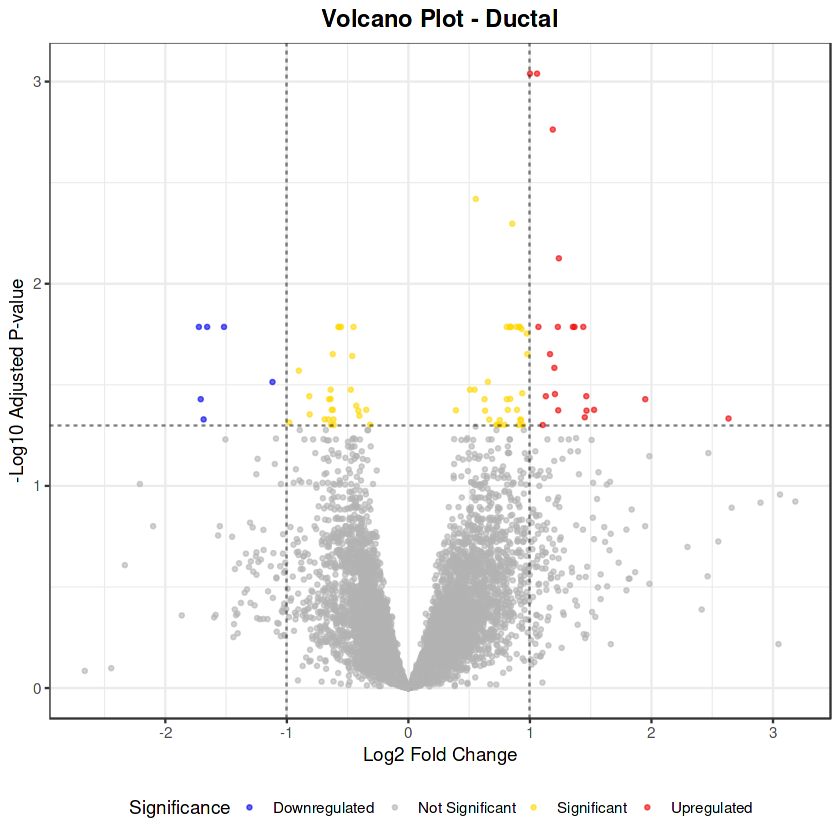


=== ANALYSIS COMPLETE ===
Generated outputs:
1. Volcano plots for each cell type
2. Summary statistics table
3. Comparative analysis results
4. Gene lists prepared for functional analysis
5. Summary bar plot

=== TIMING SUMMARY ===
Script completed at: 2025-06-24 16:09:26 
Total execution time: 16.17366 
Total time in minutes: 0.27 


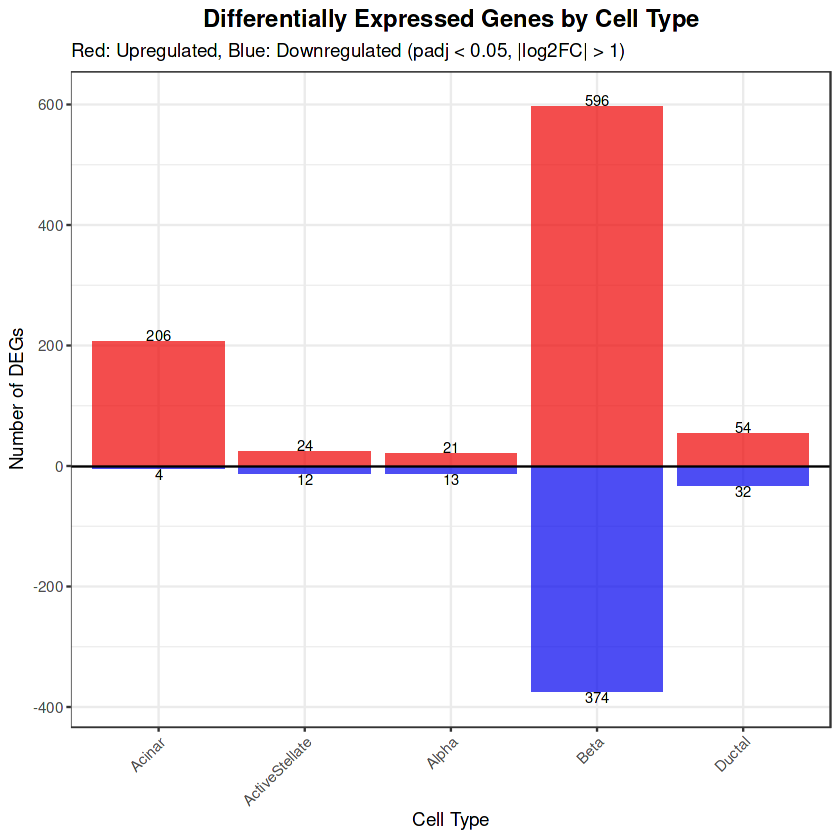

In [2]:
start_time <- Sys.time()
cat("Script started at:", format(start_time), "\n")

# Define datasets
datasets <- list(
  "Alpha" = list(
    analysis_id = "PKBDS5505XMWS",
    deg_url = "https://pankbase-data-v1.s3.us-west-2.amazonaws.com/analysis_resources/single_cell_expression/20250522_data_for_platform/Alpha_k-chosen_fdr0.05_all.txt"
  ),
  "Beta" = list(
    analysis_id = "PKBDS3519RAFX", 
    deg_url = "https://pankbase-data-v1.s3.us-west-2.amazonaws.com/analysis_resources/single_cell_expression/20250522_data_for_platform/Beta_k-chosen_fdr0.05_all.txt"
  ),
  "ActiveStellate" = list(
    analysis_id = "PKBDS3483TGEQ",
    deg_url = "https://pankbase-data-v1.s3.us-west-2.amazonaws.com/analysis_resources/single_cell_expression/20250522_data_for_platform/ActiveStellate_k-chosen_fdr0.05_all.txt"
  ),
  "Acinar" = list(
    analysis_id = "PKBDS6610NSWK",
    deg_url = "https://pankbase-data-v1.s3.us-west-2.amazonaws.com/analysis_resources/single_cell_expression/20250522_data_for_platform/Acinar_k-chosen_fdr0.05_all.txt"
  ),
  "Ductal" = list(
    analysis_id = "PKBDS8497JAAX",
    deg_url = "https://pankbase-data-v1.s3.us-west-2.amazonaws.com/analysis_resources/single_cell_expression/20250522_data_for_platform/Ductal_k-chosen_fdr0.05_all.txt"
  )
)

# Base URLs
base_url <- "https://api.data.pankbase.org"

# Function to safely query API
safe_api_query <- function(url) {
  tryCatch({
    response <- GET(url)
    if (status_code(response) == 200) {
      return(fromJSON(content(response, "text", encoding = "UTF-8")))
    } else {
      warning(paste("API request failed for:", url, "Status:", status_code(response)))
      return(NULL)
    }
  }, error = function(e) {
    warning(paste("Error querying:", url, "-", e$message))
    return(NULL)
  })
}

# Function to load DEG data from S3
load_deg_data <- function(url, cell_type) {
  cat("Loading DEG data for", cell_type, "from:", url, "\n")
  tryCatch({
    # Increase timeout for large files
    options(timeout = 300)
    deg_data <- read_tsv(url, show_col_types = FALSE)
    deg_data$cell_type <- cell_type
    cat("Successfully loaded", nrow(deg_data), "genes for", cell_type, "\n")
    return(deg_data)
  }, error = function(e) {
    warning(paste("Failed to load DEG data for", cell_type, ":", e$message))
    return(NULL)
  })
}

# Load all datasets
cat("=== LOADING DEG DATASETS ===\n")
all_deg_data <- list()
metadata_list <- list()

for (cell_type in names(datasets)) {
  cat("\n--- Processing", cell_type, "---\n")
  
  # Query API for metadata
  analysis_url <- paste0(base_url, "/analysis-sets/", datasets[[cell_type]]$analysis_id, "/")
  metadata <- safe_api_query(analysis_url)
  
  if (!is.null(metadata)) {
    cat("Analysis description:", metadata$description, "\n")
    metadata_list[[cell_type]] <- metadata
  }
  
  # Load DEG data
  deg_data <- load_deg_data(datasets[[cell_type]]$deg_url, cell_type)
  if (!is.null(deg_data)) {
    all_deg_data[[cell_type]] <- deg_data
  }
}

# Combine all DEG data
if (length(all_deg_data) > 0) {
  combined_deg <- do.call(rbind, all_deg_data)
  cat("\nCombined dataset contains", nrow(combined_deg), "total entries across", 
      length(unique(combined_deg$cell_type)), "cell types\n")
  
  # Summary statistics
  cat("\n=== SUMMARY STATISTICS ===\n")
  summary_stats <- combined_deg %>%
    group_by(cell_type) %>%
    summarise(
      total_genes = n(),
      upregulated = sum(log2FoldChange > 0 & padj < 0.05, na.rm = TRUE),
      downregulated = sum(log2FoldChange < 0 & padj < 0.05, na.rm = TRUE),
      significant = sum(padj < 0.05, na.rm = TRUE),
      .groups = 'drop'
    )
  print(summary_stats)
  
  # === VOLCANO PLOTS ===
  cat("\n=== CREATING VOLCANO PLOTS ===\n")
  
  # Function to create volcano plot
  create_volcano_plot <- function(data, title) {
    # Add significance categories
    data$significance <- "Not Significant"
    data$significance[data$padj < 0.05 & data$log2FoldChange > 1] <- "Upregulated"
    data$significance[data$padj < 0.05 & data$log2FoldChange < -1] <- "Downregulated"
    data$significance[data$padj < 0.05 & abs(data$log2FoldChange) < 1] <- "Significant"
    
    # Create plot
    p <- ggplot(data, aes(x = log2FoldChange, y = -log10(padj), color = significance)) +
      geom_point(alpha = 0.6, size = 0.8) +
      scale_color_manual(values = c(
        "Not Significant" = "grey70",
        "Significant" = "gold",
        "Upregulated" = "red2", 
        "Downregulated" = "blue2"
      )) +
      geom_vline(xintercept = c(-1, 1), linetype = "dashed", alpha = 0.5) +
      geom_hline(yintercept = -log10(0.05), linetype = "dashed", alpha = 0.5) +
      labs(
        title = paste("Volcano Plot -", title),
        x = "Log2 Fold Change",
        y = "-Log10 Adjusted P-value",
        color = "Significance"
      ) +
      theme_bw() +
      theme(
        plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
        legend.position = "bottom"
      )
    
    return(p)
  }
  
  # Create volcano plots for each cell type
  volcano_plots <- list()
  for (cell_type in names(all_deg_data)) {
    if (!is.null(all_deg_data[[cell_type]])) {
      volcano_plots[[cell_type]] <- create_volcano_plot(all_deg_data[[cell_type]], cell_type)
      print(volcano_plots[[cell_type]])
    }
  }  
  
  # === COMPARATIVE ANALYSIS ===
  cat("\n=== COMPARATIVE ANALYSIS ===\n")
  
  # Find common significantly upregulated genes
  sig_up_genes <- combined_deg %>%
    filter(padj < 0.05 & log2FoldChange > 1) %>%
    group_by(gene) %>%
    summarise(
      cell_types = paste(cell_type, collapse = ", "),
      n_cell_types = n(),
      avg_log2fc = mean(log2FoldChange),
      .groups = 'drop'
    ) %>%
    arrange(desc(n_cell_types), desc(avg_log2fc))
  
  cat("Top genes upregulated across multiple cell types:\n")
  print(head(sig_up_genes %>% filter(n_cell_types > 1), 10))
  
  # Find cell-type specific genes
  specific_genes <- combined_deg %>%
    filter(padj < 0.05 & abs(log2FoldChange) > 1) %>%
    group_by(gene) %>%
    filter(n() == 1) %>%
    ungroup() %>%
    arrange(cell_type, desc(abs(log2FoldChange)))
  
  cat("\nCell-type specific DEGs (top 5 per cell type):\n")
  specific_summary <- specific_genes %>%
    group_by(cell_type) %>%
    slice_head(n = 5) %>%
    select(cell_type, gene, log2FoldChange, padj)
  print(specific_summary)
  
  # === FUNCTIONAL ANALYSIS PREPARATION ===
  cat("\n=== PREPARING FOR FUNCTIONAL ANALYSIS ===\n")
  
  # Create gene lists for each cell type (for GO/KEGG analysis)
  gene_lists <- list()
  for (cell_type in names(all_deg_data)) {
    if (!is.null(all_deg_data[[cell_type]])) {
      # Upregulated genes
      gene_lists[[paste0(cell_type, "_up")]] <- all_deg_data[[cell_type]] %>%
        filter(padj < 0.05 & log2FoldChange > 1) %>%
        pull(gene)
      
      # Downregulated genes  
      gene_lists[[paste0(cell_type, "_down")]] <- all_deg_data[[cell_type]] %>%
        filter(padj < 0.05 & log2FoldChange < -1) %>%
        pull(gene)
    }
  }
  
  # Print gene list sizes
  cat("Gene list sizes for functional analysis:\n")
  for (list_name in names(gene_lists)) {
    cat(paste0(list_name, ": ", length(gene_lists[[list_name]]), " genes\n"))
  }
  
  # === SUMMARY PLOT ===
  cat("\n=== CREATING SUMMARY PLOT ===\n")
  
  # Bar plot of DEG counts
  summary_plot <- ggplot(summary_stats, aes(x = cell_type)) +
    geom_col(aes(y = upregulated), fill = "red2", alpha = 0.7, position = "identity") +
    geom_col(aes(y = -downregulated), fill = "blue2", alpha = 0.7, position = "identity") +
    geom_text(aes(y = upregulated + 10, label = upregulated), size = 3) +
    geom_text(aes(y = -downregulated - 10, label = downregulated), size = 3) +
    labs(
      title = "Differentially Expressed Genes by Cell Type",
      x = "Cell Type",
      y = "Number of DEGs",
      subtitle = "Red: Upregulated, Blue: Downregulated (padj < 0.05, |log2FC| > 1)"
    ) +
    theme_bw() +
    theme(
      plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
      axis.text.x = element_text(angle = 45, hjust = 1)
    ) +
    geom_hline(yintercept = 0, linetype = "solid", color = "black")
  
  print(summary_plot)
  
  cat("\n=== ANALYSIS COMPLETE ===\n")
  cat("Generated outputs:\n")
  cat("1. Volcano plots for each cell type\n")
  cat("2. Summary statistics table\n")
  cat("3. Comparative analysis results\n")
  cat("4. Gene lists prepared for functional analysis\n")
  cat("5. Summary bar plot\n")
  
} else {
  cat("No DEG data was successfully loaded.\n")
}
# At the very end
end_time <- Sys.time()
total_time <- end_time - start_time
cat("\n=== TIMING SUMMARY ===\n")
cat("Script completed at:", format(end_time), "\n")
cat("Total execution time:", total_time, "\n")
cat("Total time in minutes:", round(as.numeric(total_time, units = "mins"), 2), "\n")

## Your Downstream Analysis Starts Here!!

### **Primary DEG Characterization**

### **Functional Enrichment Analysis**
- **Gene Ontology (GO) enrichment** - Biological processes, molecular functions, cellular components
- **KEGG pathway analysis** - Metabolic and signaling pathway overrepresentation
- **Reactome pathway mapping** - Detailed biochemical reaction networks
- **Gene Set Enrichment Analysis (GSEA)** - Rank-based functional analysis using full gene lists
- **Custom pancreatic gene sets** - Diabetes, insulin signaling, pancreatic development signatures

### **Comparative Cell Type Analysis**

### **Pathway and Network Analysis**

### **Integration with External Data**

### **Validation and Follow-up Studies**
